In [0]:
# Importing Libraries

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = '/content/drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. 
    """
    filename = f'/content/drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [13]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters

epochs = 30
batch_size = 16
n_hidden = 32


In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [17]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [18]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
print(n_classes)

128
9
7352
6


In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

- Defining the Architecture of LSTM

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/30




7352/7352 [==============================] - 35s 5ms/step - loss: 1.3084 - acc: 0.4425 - val_loss: 1.1184 - val_acc: 0.4822
Epoch 2/30
7352/7352 [==============================] - 34s 5ms/step - loss: 0.9628 - acc: 0.5876 - val_loss: 0.9257 - val_acc: 0.5606
Epoch 3/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.7721 - acc: 0.6538 - val_loss: 0.7807 - val_acc: 0.6142
Epoch 4/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.6918 - acc: 0.6669 - val_loss: 0.7274 - val_acc: 0.6121
Epoch 5/30
7352/7352 [==============================] - 34s 5ms/step - loss: 0.6357 - acc: 0.6938 - val_loss: 0.6743 - val_acc: 0.6518
Epoch 6/30
7352/7352 [==============================] - 34s 5ms/step - loss: 0.5906 - acc: 0.7067 - val_loss: 0.7713 - val_acc: 0.6773
Epoch 7/30
7352/7352 [====================

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                 0
SITTING                  3      384  ...                   0                 0
STANDING                 0       86  ...                   0                 0
WALKING                  2        0  ...                  25                 6
WALKING_DOWNSTAIRS       0        0  ...                 409                10
WALKING_UPSTAIRS         2        1  ...                   0               461

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 366us/step


In [0]:
score

[0.3678714334553279, 0.9056667797760435]

<h3> Hyperparameter Tuning </h3>

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
def create_model(dropout_rate=0.0,n_hidden=1):
    model = Sequential()
    model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [0]:
# define the grid search parameters
model = KerasClassifier(build_fn=create_model)
n_hidden = [20, 25, 30, 35, 40, 45, 50]
dropout_rate = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, n_hidden=n_hidden)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1




7352/7352 [==============================] - 16s 2ms/step - loss: 0.3306 - acc: 0.8700
Best: 0.881619 using {'dropout_rate': 0.5, 'n_hidden': 40}


In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
a=grid_result.best_params_['dropout_rate']
p = grid_result.best_params_['n_hidden']
print(grid_result.best_score_)
print(a)
print(p)

0.8816190913489047
0.5
40


In [0]:
model = Sequential()
model.add(LSTM(units=p, input_shape=(timesteps, input_dim)))
model.add(Dropout(rate=a))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=30)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.1733 - acc: 0.9412 - val_loss: 0.4180 - val_acc: 0.9002
Epoch 2/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.1816 - acc: 0.9395 - val_loss: 0.3613 - val_acc: 0.9006
Epoch 3/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.1699 - acc: 0.9471 - val_loss: 0.3931 - val_acc: 0.9043
Epoch 4/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.1559 - acc: 0.9455 - val_loss: 0.7451 - val_acc: 0.8758
Epoch 5/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.1687 - acc: 0.9418 - val_loss: 0.4324 - val_acc: 0.9036
Epoch 6/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.1613 - acc: 0.9453 - val_loss: 0.3779 - val_acc: 0.9101
Epoch 7/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.1483 - acc: 0.9474 - val_loss: 0.5106 - val_acc: 0.8873
Epoch 8

Test score: 0.281517137235211
Test accuracy: 0.9280624363759755


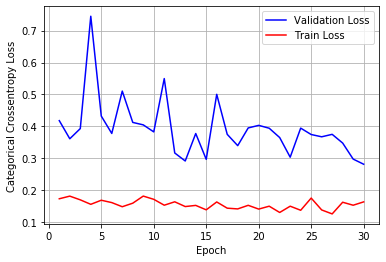

In [0]:
import matplotlib.pyplot as plt
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1)) #List of epoch numbers
val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_dynamic(x, val_loss, loss, ax) #Display the model

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 511        0  ...                   0                 0
SITTING                  0      367  ...                   2                 1
STANDING                 0       45  ...                   0                 1
WALKING                  0        0  ...                  13                 7
WALKING_DOWNSTAIRS       0        0  ...                 412                 5
WALKING_UPSTAIRS         2        3  ...                   9               420

[6 rows x 6 columns]


From Hyperparameter Tuning, we got our desired result as accuracy is 93%

<h3> 2 LSTM Layers having 32 LSTM units + Dropout (0.8) <h3>

In [0]:
# Initializing parameters
epochs = 30
batch_size = 32
n_hidden = n_hidden

In [0]:
# Initiliazing the sequential model
model = Sequential()

#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#Multilayer LSTM 

model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(Dropout(0.8))
model.add(LSTM(32,input_shape=(timesteps, 32)))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 32)                8320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 198       
Total params: 14,022
Trainable params: 13,958
Non-trainable params: 64
________________________________________________

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 37s 5ms/step - loss: 1.4897 - acc: 0.4070 - val_loss: 1.0906 - val_acc: 0.5083
Epoch 2/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.1085 - acc: 0.5170 - val_loss: 0.8929 - val_acc: 0.4968
Epoch 3/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.9380 - acc: 0.5239 - val_loss: 0.8232 - val_acc: 0.4910
Epoch 4/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.8682 - acc: 0.5229 - val_loss: 0.8501 - val_acc: 0.5046
Epoch 5/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.8571 - acc: 0.5231 - val_loss: 0.7841 - val_acc: 0.5148
Epoch 6/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.8264 - acc: 0.5209 - val_loss: 0.8508 - val_acc: 0.5053
Epoch 7/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.8265 - acc: 0.5299 - val_loss: 0.8444 - val_acc: 0.5073
Epoch 8

Test score: nan
Test accuracy: 0.168306752629793


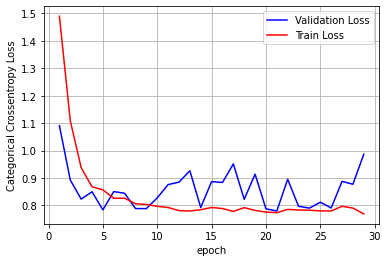

In [0]:
import matplotlib.pyplot as plt
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                WALKING
True                       
LAYING                  537
SITTING                 491
STANDING                532
WALKING                 496
WALKING_DOWNSTAIRS      420
WALKING_UPSTAIRS        471


<h3> 2 LSTM Layers having 32 LSTM units + Dropout (0.7) </h3>

In [0]:
# Initializing parameters
epochs = 30
batch_size = 32
n_hidden = n_hidden

In [0]:
# Initiliazing the sequential model
model = Sequential()

#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#Multilayer LSTM 

model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(Dropout(0.7))
model.add(LSTM(32,input_shape=(timesteps, 32)))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_17 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                8320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 198       
Total params: 14,022
Trainable params: 13,958
Non-trainable params: 64
________________________________________________

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 37s 5ms/step - loss: 1.3051 - acc: 0.4592 - val_loss: 0.9059 - val_acc: 0.5372
Epoch 2/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.9109 - acc: 0.5654 - val_loss: 0.8365 - val_acc: 0.5232
Epoch 3/30
7352/7352 [==============================] - 33s 5ms/step - loss: 0.8262 - acc: 0.5479 - val_loss: 0.7616 - val_acc: 0.5110
Epoch 4/30
7352/7352 [==============================] - 33s 5ms/step - loss: 0.7878 - acc: 0.5192 - val_loss: 0.7428 - val_acc: 0.5182
Epoch 5/30
7352/7352 [==============================] - 33s 5ms/step - loss: 0.7610 - acc: 0.5309 - val_loss: 0.7328 - val_acc: 0.5165
Epoch 6/30
7352/7352 [==============================] - 33s 4ms/step - loss: 0.7503 - acc: 0.5181 - val_loss: 0.7360 - val_acc: 0.5087
Epoch 7/30
7352/7352 [==============================] - 33s 5ms/step - loss: 0.7408 - acc: 0.5272 - val_loss: 0.7539 - val_acc: 0.5090
Epoch 8

Test score: 0.6915614812784582
Test accuracy: 0.6012894468951476


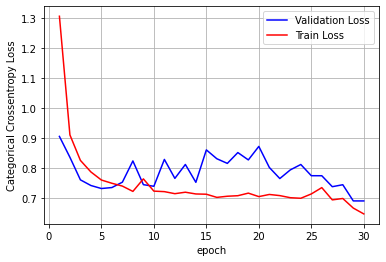

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  WALKING  WALKING_UPSTAIRS
True                                                          
LAYING                 537        0        0                 0
SITTING                  7      484        0                 0
STANDING                 0      530        0                 2
WALKING                  0        0      329               167
WALKING_DOWNSTAIRS       0        0      410                10
WALKING_UPSTAIRS         0        0       49               422


<h3> 2 LSTM Layers having 32 LSTM units + Dropout (0.6) </h3>

In [0]:
# Initializing parameters
epochs = 30
batch_size = 32
n_hidden = n_hidden

In [0]:
# Initiliazing the sequential model
model = Sequential()

#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#Multilayer LSTM 

model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(LSTM(16,input_shape=(timesteps, 32)))
model.add(Dropout(0.6))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 102       
Total params: 8,614
Trainable params: 8,614
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 30s 4ms/step - loss: 1.4606 - acc: 0.3541 - val_loss: 1.3909 - val_acc: 0.3804
Epoch 2/10
7352/7352 [==============================] - 28s 4ms/step - loss: 1.2772 - acc: 0.4445 - val_loss: 1.2393 - val_acc: 0.4761
Epoch 3/10
7352/7352 [==============================] - 29s 4ms/step - loss: 1.1170 - acc: 0.5462 - val_loss: 1.0281 - val_acc: 0.5758
Epoch 4/10
7352/7352 [==============================] - 29s 4ms/step - loss: 0.9835 - acc: 0.5845 - val_loss: 0.8755 - val_acc: 0.6098
Epoch 5/10
7352/7352 [==============================] - 29s 4ms/step - loss: 0.8978 - acc: 0.6122 - val_loss: 0.8016 - val_acc: 0.5982
Epoch 6/10
7352/7352 [==============================] - 29s 4ms/step - loss: 0.8770 - acc: 0.6058 - val_loss: 0.7879 - val_acc: 0.6115
Epoch 7/10
7352/7352 [==============================] - 27s 4ms/step - loss: 0.8076 - acc: 0.6306 - val_loss: 0.7607 - val_acc: 0.6132
Epoch 8

Test score: 0.7825939169891171
Test accuracy: 0.6223277909738717


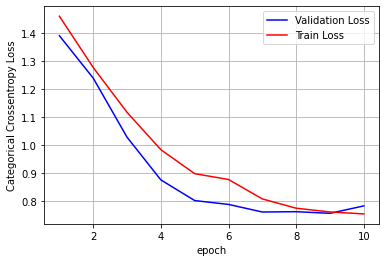

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING
True                                                  
LAYING                 510        0        27        0
SITTING                  0      365       116       10
STANDING                 0       51       463       18
WALKING                  0        0         0      496
WALKING_DOWNSTAIRS       0        0         0      420
WALKING_UPSTAIRS         0        0         0      471


<h3> 2 LSTM Layers having 32 LSTM units + Dropout (0.5) </h3>

In [0]:
# Initiliazing the sequential model
model = Sequential()

#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#Multilayer LSTM 

model.add(LSTM(32,return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))
model.add(LSTM(32,input_shape=(timesteps, 32)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_19 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                8320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 198       
Total params: 14,022
Trainable params: 13,958
Non-trainable params: 64
________________________________________________

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 38s 5ms/step - loss: 1.1372 - acc: 0.5460 - val_loss: 0.8200 - val_acc: 0.6498
Epoch 2/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.7995 - acc: 0.6140 - val_loss: 0.7844 - val_acc: 0.6651
Epoch 3/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.7634 - acc: 0.6027 - val_loss: 0.7524 - val_acc: 0.6206
Epoch 4/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.7211 - acc: 0.6030 - val_loss: 0.7840 - val_acc: 0.5344
Epoch 5/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.7106 - acc: 0.5915 - val_loss: 0.7795 - val_acc: 0.5219
Epoch 6/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.7023 - acc: 0.5811 - val_loss: 0.7558 - val_acc: 0.5324
Epoch 7/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.6699 - acc: 0.6011 - val_loss: 0.7179 - val_acc: 0.6155
Epoch 8

Test score: 0.5203237037180645
Test accuracy: 0.7712928401764506


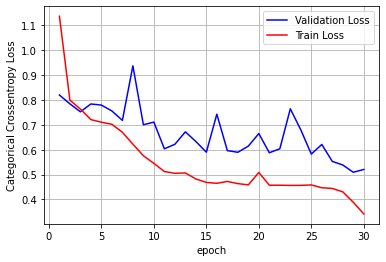

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_UPSTAIRS
True                                                                    
LAYING                 537        0         0        0                 0
SITTING                  8      368        98        0                17
STANDING                 0       74       458        0                 0
WALKING                  0        0         5      450                41
WALKING_DOWNSTAIRS       0        0         0        1               419
WALKING_UPSTAIRS         0        2         1        8               460


<h3> 2 LSTM Layers having 32 LSTM units + Dropout (0.4) </h3>

In [0]:
# Initiliazing the sequential model
model = Sequential()

#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#Multilayer LSTM 

model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(LSTM(16,input_shape=(timesteps, 32)))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102       
Total params: 8,614
Trainable params: 8,614
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 28s 4ms/step - loss: 1.3801 - acc: 0.4603 - val_loss: 1.1242 - val_acc: 0.4927
Epoch 2/10
7352/7352 [==============================] - 26s 4ms/step - loss: 1.0014 - acc: 0.5684 - val_loss: 0.9022 - val_acc: 0.5830
Epoch 3/10
7352/7352 [==============================] - 25s 3ms/step - loss: 0.8792 - acc: 0.6249 - val_loss: 0.8048 - val_acc: 0.6186
Epoch 4/10
7352/7352 [==============================] - 26s 3ms/step - loss: 0.7942 - acc: 0.6629 - val_loss: 0.7416 - val_acc: 0.6854
Epoch 5/10
7352/7352 [==============================] - 26s 4ms/step - loss: 0.7436 - acc: 0.6930 - val_loss: 0.6989 - val_acc: 0.7065
Epoch 6/10
7352/7352 [==============================] - 26s 3ms/step - loss: 0.7190 - acc: 0.7035 - val_loss: 0.6275 - val_acc: 0.7380
Epoch 7/10
7352/7352 [==============================] - 26s 3ms/step - loss: 0.6266 - acc: 0.7406 - val_loss: 0.6459 - val_acc: 0.7129
Epoch 8

Test score: 0.5131604391759155
Test accuracy: 0.7692568714148641


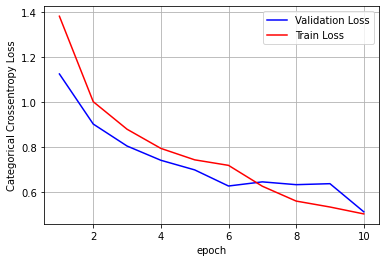

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  0      463  ...                   7                 0
STANDING                 0      182  ...                   1                 3
WALKING                  0        1  ...                   2                43
WALKING_DOWNSTAIRS       0        1  ...                 167               234
WALKING_UPSTAIRS         0        0  ...                  96               310

[6 rows x 6 columns]


<h3> 2 LSTM Layers having 64 LSTM units + Dropout (0.5) </h3>

In [0]:
# Initializing parameters
epochs = 30
batch_size = 32
n_hidden = n_hidden

In [0]:
from keras.layers.normalization import BatchNormalization
# Initiliazing the sequential model
model = Sequential()

#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#Multilayer LSTM 

model.add(LSTM(128, return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))
model.add(LSTM(128,input_shape=(timesteps,input_dim)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 203,526
Trainable params: 203,270
Non-trainable params: 256
______________________________________________

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
# patient early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# ModelCheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('30epoch_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs, callbacks=[es, mc])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 109s 15ms/step - loss: 1.1494 - acc: 0.4736 - val_loss: 2.0248 - val_acc: 0.4153

Epoch 00001: val_acc improved from -inf to 0.41534, saving model to 30epoch_model.h5
Epoch 2/30
7352/7352 [==============================] - 98s 13ms/step - loss: 0.9132 - acc: 0.5966 - val_loss: 0.8148 - val_acc: 0.6366

Epoch 00002: val_acc improved from 0.41534 to 0.63658, saving model to 30epoch_model.h5
Epoch 3/30
7352/7352 [==============================] - 99s 13ms/step - loss: 0.7147 - acc: 0.6382 - val_loss: 0.8006 - val_acc: 0.5626

Epoch 00003: val_acc did not improve from 0.63658
Epoch 4/30
7352/7352 [==============================] - 100s 14ms/step - loss: 0.6770 - acc: 0.6609 - val_loss: 0.6875 - val_acc: 0.6783

Epoch 00004: val_acc improved from 0.63658 to 0.67832, saving model to 30epoch_model.h5
Epoch 5/30
7352/7352 [==============================] - 99s 13ms/step - loss: 0.6310 - acc:

Test score: 0.2615530221774433
Test accuracy: 0.9199185612487275


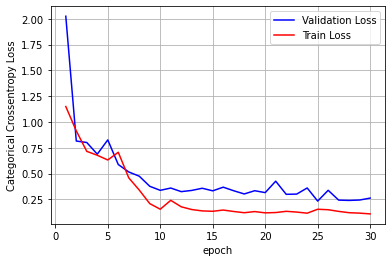

In [0]:
import matplotlib.pyplot as plt
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  5      384  ...                   0                 4
STANDING                 0       98  ...                   0                 1
WALKING                  0        0  ...                  25                 2
WALKING_DOWNSTAIRS       0        0  ...                 417                 2
WALKING_UPSTAIRS         0        0  ...                   0               471

[6 rows x 6 columns]


In [0]:
# Save the model
model.save("30epoch_model.h5")

In [0]:
from numpy import loadtxt
from keras.models import load_model
models = load_model('30epoch_model.h5')

In [0]:
models.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 203,526
Trainable params: 203,270
Non-trainable params: 256
______________________________________________

In [0]:
# Compiling the model
models.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
# patient early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# ModelCheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('80epoch_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
# Training the model
history5=models.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=10, callbacks=[es, mc])
score = models.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 108s 15ms/step - loss: 0.1179 - acc: 0.9487 - val_loss: 0.2702 - val_acc: 0.9274

Epoch 00001: val_acc improved from -inf to 0.92738, saving model to 80epoch_model.h5
Epoch 2/10
7352/7352 [==============================] - 99s 13ms/step - loss: 0.1437 - acc: 0.9437 - val_loss: 0.3799 - val_acc: 0.9026

Epoch 00002: val_acc did not improve from 0.92738
Epoch 3/10
7352/7352 [==============================] - 99s 14ms/step - loss: 0.1181 - acc: 0.9538 - val_loss: 0.3505 - val_acc: 0.9125

Epoch 00003: val_acc did not improve from 0.92738
Epoch 4/10
7352/7352 [==============================] - 100s 14ms/step - loss: 0.1186 - acc: 0.9497 - val_loss: 0.3242 - val_acc: 0.9131

Epoch 00004: val_acc did not improve from 0.92738
Epoch 5/10
7352/7352 [==============================] - 99s 14ms/step - loss: 0.1625 - acc: 0.9354 - val_loss: 0.3209 - val_acc: 0.9084

Epoch 00005: val_acc did not i

Test score: 0.3136977848725028
Test accuracy: 0.9148286392941974


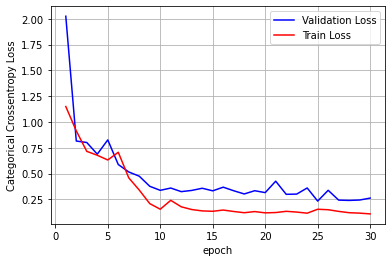

In [0]:
import matplotlib.pyplot as plt
score = models.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Save the model
models.save("80epoch_model.h5")

<h3> 2 LSTM Layers having 128 LSTM units + Dropout (0.5) </h3>

In [0]:
# Initializing parameters
epochs = 30
batch_size = 32
n_hidden = n_hidden

In [0]:
# Initiliazing the sequential model
model = Sequential()

#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#Multilayer LSTM 

model.add(LSTM(128, return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))
model.add(LSTM(128,input_shape=(timesteps, 32)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 128, 128)          70656     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 128)               131584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 774       
Total params: 203,526
Trainable params: 203,270
Non-trainable params: 256
_____________________________________________

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# patient early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# ModelCheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('128layer_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs, callbacks=[es, mc])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.9964 - acc: 0.5520 - val_loss: 1.1033 - val_acc: 0.5969

Epoch 00001: val_acc improved from -inf to 0.59688, saving model to 128layer_model.h5
Epoch 2/30
7352/7352 [==============================] - 89s 12ms/step - loss: 0.7406 - acc: 0.6270 - val_loss: 1.1731 - val_acc: 0.4791

Epoch 00002: val_acc did not improve from 0.59688
Epoch 3/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.6767 - acc: 0.6398 - val_loss: 0.8352 - val_acc: 0.6111

Epoch 00003: val_acc improved from 0.59688 to 0.61113, saving model to 128layer_model.h5
Epoch 4/30
7352/7352 [==============================] - 88s 12ms/step - loss: 0.6673 - acc: 0.6425 - val_loss: 0.8016 - val_acc: 0.6193

Epoch 00004: val_acc improved from 0.61113 to 0.61927, saving model to 128layer_model.h5
Epoch 5/30
7352/7352 [==============================] - 88s 12ms/step - loss: 0.6483 - acc

Test score: 0.27744862166333983
Test accuracy: 0.9178825924669155


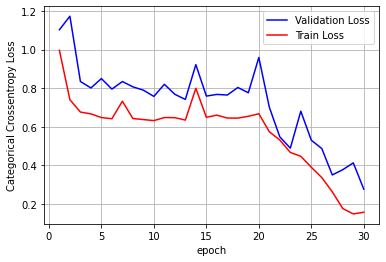

In [0]:
import matplotlib.pyplot as plt
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  5      305  ...                   0                19
STANDING                 0       26  ...                   0                 0
WALKING                  0        0  ...                  19                 8
WALKING_DOWNSTAIRS       0        0  ...                 419                 1
WALKING_UPSTAIRS         0        0  ...                  22               449

[6 rows x 6 columns]


In [0]:
# Save the model
model.save("128layer_model.h5")

In [0]:
from numpy import loadtxt
from keras.models import load_model
model_1 = load_model('128layer_model.h5')

In [0]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 203,526
Trainable params: 203,270
Non-trainable params: 256
______________________________________________

In [0]:
# patient early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# ModelCheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('30epoch_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
# Training the model
history3=model_1.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=30, callbacks=[es, mc])
score = model_1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.2056 - acc: 0.9416 - val_loss: 0.4322 - val_acc: 0.9111

Epoch 00001: val_acc improved from -inf to 0.91110, saving model to 30epoch_model.h5
Epoch 2/30
7352/7352 [==============================] - 91s 12ms/step - loss: 0.1639 - acc: 0.9415 - val_loss: 0.3321 - val_acc: 0.9216

Epoch 00002: val_acc improved from 0.91110 to 0.92162, saving model to 30epoch_model.h5
Epoch 3/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.1543 - acc: 0.9446 - val_loss: 0.6659 - val_acc: 0.8938

Epoch 00003: val_acc did not improve from 0.92162
Epoch 4/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.1392 - acc: 0.9510 - val_loss: 0.5478 - val_acc: 0.9108

Epoch 00004: val_acc did not improve from 0.92162
Epoch 5/30
7352/7352 [==============================] - 89s 12ms/step - loss: 0.1407 - acc: 0.9510 - val_loss: 0.5278 - val_acc: 0.

Test score: 0.4867024210958139
Test accuracy: 0.9178825924669155


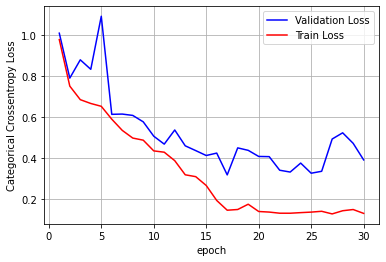

In [0]:
score = model_1.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model_1.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 512        0  ...                   0                 0
SITTING                  0      380  ...                   0                 2
STANDING                 0       67  ...                   0                 0
WALKING                  0        2  ...                  10                 1
WALKING_DOWNSTAIRS       0        0  ...                 420                 0
WALKING_UPSTAIRS         0        4  ...                  18               448

[6 rows x 6 columns]


In [0]:
# Save the model
model_1.save("30epoch_model.h5")

In [0]:
from numpy import loadtxt
from keras.models import load_model
model_2 = load_model('30epoch_model.h5')

In [0]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 203,526
Trainable params: 203,270
Non-trainable params: 256
______________________________________________

In [0]:
# patient early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# ModelCheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('60epoch_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
# Training the model
history4=model_2.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=15, callbacks=[es, mc])
score = model_2.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 95s 13ms/step - loss: 0.1421 - acc: 0.9518 - val_loss: 0.4184 - val_acc: 0.9080

Epoch 00001: val_acc improved from -inf to 0.90804, saving model to 60epoch_model.h5
Epoch 2/15
7352/7352 [==============================] - 93s 13ms/step - loss: 0.1268 - acc: 0.9518 - val_loss: 0.4107 - val_acc: 0.9233

Epoch 00002: val_acc improved from 0.90804 to 0.92331, saving model to 60epoch_model.h5
Epoch 3/15
7352/7352 [==============================] - 94s 13ms/step - loss: 0.1192 - acc: 0.9502 - val_loss: 0.4966 - val_acc: 0.9145

Epoch 00003: val_acc did not improve from 0.92331
Epoch 4/15
7352/7352 [==============================] - 94s 13ms/step - loss: 0.1290 - acc: 0.9510 - val_loss: 0.3688 - val_acc: 0.9233

Epoch 00004: val_acc did not improve from 0.92331
Epoch 5/15
7352/7352 [==============================] - 96s 13ms/step - loss: 0.1259 - acc: 0.9514 - val_loss: 0.3129 - val_acc: 0.

Test score: 0.5388459812360064
Test accuracy: 0.8937902952154734


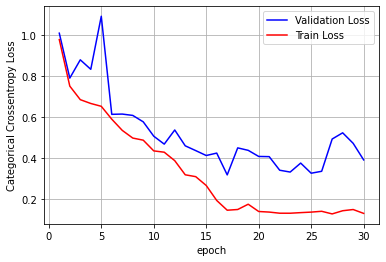

In [0]:
score = model_2.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Save the model
model_2.save("60epoch_model.h5")

In [0]:
from numpy import loadtxt
from keras.models import load_model
model_3 = load_model('60epoch_model.h5')

In [0]:
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 203,526
Trainable params: 203,270
Non-trainable params: 256
______________________________________________

In [0]:
# Compiling the model
model_3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# patient early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# ModelCheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('70epoch_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
# Training the model
history4=model_3.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=15, callbacks=[es, mc])
score = model_3.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 98s 13ms/step - loss: 0.1583 - acc: 0.9452 - val_loss: 0.2918 - val_acc: 0.9281

Epoch 00001: val_acc improved from -inf to 0.92806, saving model to 70epoch_model.h5
Epoch 2/15
7352/7352 [==============================] - 94s 13ms/step - loss: 0.1946 - acc: 0.9484 - val_loss: 0.4710 - val_acc: 0.9026

Epoch 00002: val_acc did not improve from 0.92806
Epoch 3/15
7352/7352 [==============================] - 94s 13ms/step - loss: 0.1410 - acc: 0.9470 - val_loss: 0.5007 - val_acc: 0.9175

Epoch 00003: val_acc did not improve from 0.92806
Epoch 4/15
7352/7352 [==============================] - 94s 13ms/step - loss: 0.1260 - acc: 0.9493 - val_loss: 0.5708 - val_acc: 0.9050

Epoch 00004: val_acc did not improve from 0.92806
Epoch 5/15
7352/7352 [==============================] - 94s 13ms/step - loss: 0.1395 - acc: 0.9501 - val_loss: 0.5541 - val_acc: 0.9019

Epoch 00005: val_acc did not imp

Test score: 0.4395436131623223
Test accuracy: 0.9127926705123854


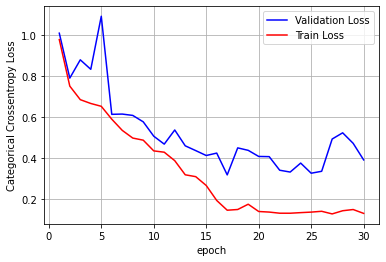

In [0]:
score = model_3.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Save the model
model_3.save("70epoch_model.h5")

In [0]:
from numpy import loadtxt
from keras.models import load_model
model_4 = load_model('70epoch_model.h5')

In [0]:
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 203,526
Trainable params: 203,270
Non-trainable params: 256
______________________________________________

In [0]:
# Compiling the model
model_4.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# patient early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# ModelCheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('80epoch_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
# Training the model
history5=model_4.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=10, callbacks=[es, mc])
score = model_4.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 100s 14ms/step - loss: 0.1495 - acc: 0.9520 - val_loss: 0.5311 - val_acc: 0.9121

Epoch 00001: val_acc improved from -inf to 0.91211, saving model to 80epoch_model.h5
Epoch 2/10
7352/7352 [==============================] - 94s 13ms/step - loss: 0.1297 - acc: 0.9513 - val_loss: 0.3476 - val_acc: 0.9209

Epoch 00002: val_acc improved from 0.91211 to 0.92094, saving model to 80epoch_model.h5
Epoch 3/10
7352/7352 [==============================] - 95s 13ms/step - loss: 0.1227 - acc: 0.9524 - val_loss: 0.4481 - val_acc: 0.9084

Epoch 00003: val_acc did not improve from 0.92094
Epoch 4/10
7352/7352 [==============================] - 94s 13ms/step - loss: 0.1190 - acc: 0.9524 - val_loss: 0.4744 - val_acc: 0.9097

Epoch 00004: val_acc did not improve from 0.92094
Epoch 5/10
7352/7352 [==============================] - 93s 13ms/step - loss: 0.1088 - acc: 0.9574 - val_loss: 0.4568 - val_acc: 0

Test score: 0.45956417720007264
Test accuracy: 0.9046487953851374


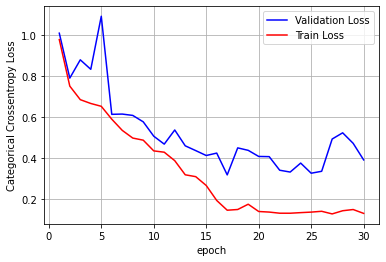

In [0]:
score = model_4.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Save the model
model_4.save("80epoch_model.h5")

In [0]:
from numpy import loadtxt
from keras.models import load_model
model_5 = load_model('80epoch_model.h5')

In [0]:
model_5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 203,526
Trainable params: 203,270
Non-trainable params: 256
______________________________________________

In [0]:
# Compiling the model
model_5.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# patient early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# ModelCheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('90epoch_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
# Training the model
history4=model_5.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=10, callbacks=[es, mc])
score = model_5.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 103s 14ms/step - loss: 0.1144 - acc: 0.9539 - val_loss: 0.4207 - val_acc: 0.9179

Epoch 00001: val_acc improved from -inf to 0.91788, saving model to 90epoch_model.h5
Epoch 2/10
7352/7352 [==============================] - 96s 13ms/step - loss: 0.1511 - acc: 0.9543 - val_loss: 0.5600 - val_acc: 0.9243

Epoch 00002: val_acc improved from 0.91788 to 0.92433, saving model to 90epoch_model.h5
Epoch 3/10
7352/7352 [==============================] - 97s 13ms/step - loss: 0.2194 - acc: 0.9467 - val_loss: 0.4281 - val_acc: 0.9203

Epoch 00003: val_acc did not improve from 0.92433
Epoch 4/10
7352/7352 [==============================] - 101s 14ms/step - loss: 0.1172 - acc: 0.9567 - val_loss: 0.3930 - val_acc: 0.9247

Epoch 00004: val_acc improved from 0.92433 to 0.92467, saving model to 90epoch_model.h5
Epoch 5/10
7352/7352 [==============================] - 103s 14ms/step - loss: 0.1302 - acc

Test score: 0.2910023735648925
Test accuracy: 0.9290804207668816


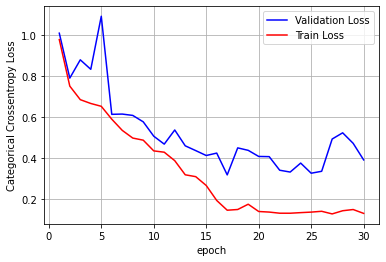

In [0]:
score = model_5.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# Save the model
model_5.save("90epoch_model.h5")

- With a simple 2 layer architecture with 128 LSTM units we got 93% accuracy and a loss of 0.29.